In [1]:
#import kaggle

In [2]:
#!kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition

In [3]:
#patoolib.extract_archive("fruit-and-vegetable-image-recognition.zip",outdir="data")

In [4]:
#import patoolib

In [5]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

2023-01-22 13:32:00.135611: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [6]:
import tensorflow.compat.v1 as tf
tf.logging.set_verbosity(tf.logging.ERROR)
a = tf.zeros(1)

2023-01-22 13:32:01.623355: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 13:32:01.630919: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 13:32:01.631560: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 13:32:01.632763: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [7]:
#!pwd

In [8]:
# Create a list with the filepaths for training and testing
train_dir = Path("./data/train/")
train_filepaths = list(train_dir.glob(r"**/*.jpg"))

test_dir = Path("./data/test")
test_filepaths = list(test_dir.glob(r"**/*.jpg"))

val_dir = Path("./data/validation")
val_filepaths = list(test_dir.glob(r"**/*.jpg"))


In [9]:
def proc_img(filepath):
    """Create a DataFrame with the filepath and the labels of the pictures"""

    labels = [str(filepath[i]).split("/")[-2] for i in range(len(filepath))]

    filepath = pd.Series(filepath, name="Filepath").astype(str)
    labels = pd.Series(labels, name="Label")

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop=True)

    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

# EDA

### Info about the training dataset

In [10]:
# check on how many images are there for each class in the training set
print("On average there are", round(sum([len(files) for r, d, files in os.walk(train_dir)]) / sum([len(d) for r, d, files in os.walk(train_dir)]), 2), 
      "images for each class in the training set.")

On average there are 86.53 images for each class in the training set.


In [11]:
print("-- Training set --\n")
print(f"Number of pictures: {train_df.shape[0]}\n")
print(f"Number of different labels: {len(train_df.Label.unique())}\n")
print(f"Labels: {train_df.Label.unique()}")

-- Training set --

Number of pictures: 2780

Number of different labels: 36

Labels: ['cucumber' 'bell pepper' 'lettuce' 'beetroot' 'sweetpotato' 'carrot'
 'watermelon' 'banana' 'peas' 'capsicum' 'pomegranate' 'pineapple' 'apple'
 'corn' 'chilli pepper' 'cabbage' 'sweetcorn' 'ginger' 'jalepeno' 'orange'
 'tomato' 'lemon' 'kiwi' 'onion' 'garlic' 'turnip' 'soy beans' 'paprika'
 'grapes' 'raddish' 'spinach' 'eggplant' 'mango' 'cauliflower' 'pear'
 'potato']


In [12]:
# The DataFrame with the filepaths in one column and the labels in the other one
train_df.head(5)

,Filepath,Label
0,data/train/cucumber/Image_28.jpg,cucumber
1,data/train/bell pepper/Image_98.jpg,bell pepper
2,data/train/lettuce/Image_93.jpg,lettuce
3,data/train/beetroot/Image_96.jpg,beetroot
4,data/train/sweetpotato/Image_39.jpg,sweetpotato


In [13]:
train_df["Label"].describe()

count          2780
unique           36
top       soy beans
freq             92
Name: Label, dtype: object

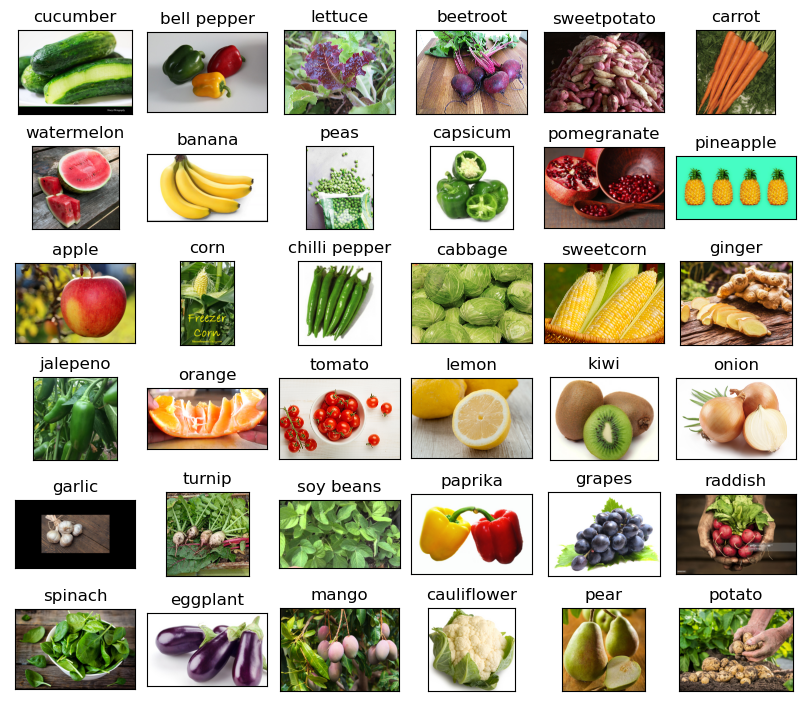

In [14]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(
    nrows=6, ncols=6, figsize=(8, 7), subplot_kw={"xticks": [], "yticks": []}
)

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize=12)
plt.tight_layout(pad=0.5)
plt.show()

# Mobilenet

In [15]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2780 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.


In [16]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [17]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5


2023-01-22 13:32:17.573784: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-01-22 13:32:18.207191: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-22 13:32:18.208220: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-22 13:32:18.208256: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-01-22 13:32:18.209226: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-22 13:32:18.209319: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


87/87 [==============================] - 120s 1s/step - loss: 1.6360 - accuracy: 0.5676 - val_loss: 0.4436 - val_accuracy: 0.8862
Epoch 2/5
87/87 [==============================] - 114s 1s/step - loss: 0.5505 - accuracy: 0.8162 - val_loss: 0.2864 - val_accuracy: 0.9162
Epoch 3/5
87/87 [==============================] - 115s 1s/step - loss: 0.3270 - accuracy: 0.8982 - val_loss: 0.2392 - val_accuracy: 0.9341
Epoch 4/5
87/87 [==============================] - 115s 1s/step - loss: 0.2071 - accuracy: 0.9309 - val_loss: 0.1902 - val_accuracy: 0.9311
Epoch 5/5
87/87 [==============================] - 114s 1s/step - loss: 0.1399 - accuracy: 0.9594 - val_loss: 0.1818 - val_accuracy: 0.9491


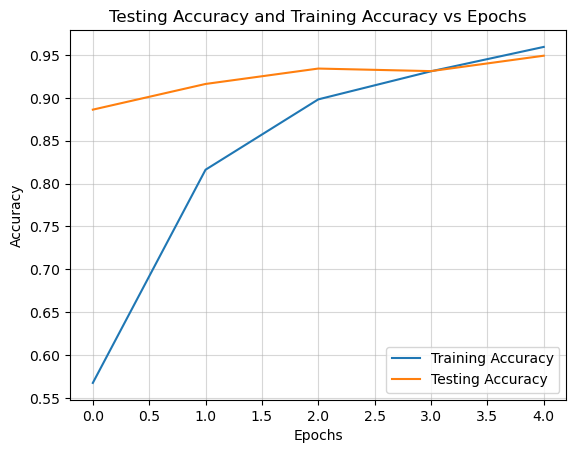

In [63]:

plt.figure(4)
plt.plot(history.history["accuracy"],label = "Training Accuracy")
plt.plot(history.history["val_accuracy"],label = "Testing Accuracy")
plt.legend()
plt.grid(axis='both',alpha=0.5)
plt.title("Testing Accuracy and Training Accuracy vs Epochs")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [22]:
# save this model
model.save('fruits_vegetables_MobileNet.h5')

In [67]:
final_model_MN = keras.models.load_model("fruits_vegetables_MobileNet.h5")


In [68]:
final_model_MN.evaluate(test_images)

11/11 [==============================] - 17s 1s/step - loss: 0.1818 - accuracy: 0.9491


[0.1818402260541916, 0.9491018056869507]

## Sequential

In [39]:
from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

### Data preprocessing
#### Image generators

In [37]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                                  horizontal_flip=True,
                                  shear_range=True,
                                  rotation_range=40,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2
                                )
training_set = train_datagen.flow_from_directory('./data/train',
                                                target_size=(64,64),
                                                batch_size=32,
                                                class_mode='categorical')


val_datagen = ImageDataGenerator(rescale=1/255.)

validation_set = val_datagen.flow_from_directory('./data/validation',
                                                target_size=(64,64),
                                                batch_size=32,
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1/255.)

test_set = test_datagen.flow_from_directory('./data/test',
                                           target_size=(64,64),
                                           batch_size=32,
                                           class_mode='categorical')

Found 3115 images belonging to 36 classes.
Found 351 images belonging to 36 classes.
Found 359 images belonging to 36 classes.


## Model training 

In [40]:
model = Sequential()

model.add(Conv2D(filters=32,activation='relu',kernel_size=(3,3),input_shape=(64,64,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,activation='relu',kernel_size=(3,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128,activation='relu',kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=256,activation='relu',kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(units=64,activation='relu'))
model.add(Dense(units=128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(units=36,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics='accuracy')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 batch_normalization (BatchN  (None, 12, 12, 128)     

## ResNet101

In [41]:
from keras.applications.resnet_v2 import ResNet101V2
from keras.models import Model

In [42]:
resnet_v2 = ResNet101V2(weights='imagenet',include_top=False,input_shape=(64,64,3))

for layer in resnet_v2.layers:
    layer.trainable = False
    
base_model = resnet_v2.output
base_model = Flatten()(base_model)
base_model = Dense(512,activation='relu')(base_model)
base_model = Dense(512,activation='relu')(base_model)
base_model = Dense(36,activation='softmax')(base_model)

model = Model(inputs=resnet_v2.input,outputs=base_model)
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics='accuracy')
model.summary();

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 34, 34, 64)   0           ['conv1_conv[0][0]']             
                                                                                            

In [43]:
es = EarlyStopping(monitor='val_accuracy',patience=90,verbose=1,mode='max')
mc = ModelCheckpoint('checkpoint/',monitor='val_accuracy',mode='max',save_best_only=True,verbose=1)
lr = ReduceLROnPlateau(monitor='val_accuracy',factor=0.1,min_lr=0.001,patience=15,mode='max',verbose=1)

r = model.fit(training_set,
              epochs=100,
              batch_size=32,
              validation_data=validation_set,
              callbacks=[es,mc,lr])

Epoch 1/100
98/98 [==============================] - ETA: 0s - loss: 3.1707 - accuracy: 0.2244
Epoch 1: val_accuracy improved from -inf to 0.52137, saving model to checkpoint/


98/98 [==============================] - 168s 2s/step - loss: 3.1707 - accuracy: 0.2244 - val_loss: 1.8035 - val_accuracy: 0.5214 - lr: 0.0010
Epoch 2/100
98/98 [==============================] - ETA: 0s - loss: 2.4102 - accuracy: 0.3509
Epoch 2: val_accuracy improved from 0.52137 to 0.58689, saving model to checkpoint/


98/98 [==============================] - 157s 2s/step - loss: 2.4102 - accuracy: 0.3509 - val_loss: 1.5239 - val_accuracy: 0.5869 - lr: 0.0010
Epoch 3/100
98/98 [==============================] - ETA: 0s - loss: 2.1973 - accuracy: 0.4077
Epoch 3: val_accuracy improved from 0.58689 to 0.62108, saving model to checkpoint/


98/98 [==============================] - 157s 2s/step - loss: 2.1973 - accuracy: 0.4077 - val_loss: 1.3962 - val_accuracy: 0.6211 - lr: 0.0010
Epoch 4/100
98/98 [==============================] - ETA: 0s - loss: 2.0188 - accuracy: 0.4446
Epoch 4: val_accuracy improved from 0.62108 to 0.64672, saving model to checkpoint/


98/98 [==============================] - 157s 2s/step - loss: 2.0188 - accuracy: 0.4446 - val_loss: 1.2803 - val_accuracy: 0.6467 - lr: 0.0010
Epoch 5/100
98/98 [==============================] - ETA: 0s - loss: 1.9404 - accuracy: 0.4758
Epoch 5: val_accuracy improved from 0.64672 to 0.64957, saving model to checkpoint/


98/98 [==============================] - 157s 2s/step - loss: 1.9404 - accuracy: 0.4758 - val_loss: 1.2354 - val_accuracy: 0.6496 - lr: 0.0010
Epoch 6/100
98/98 [==============================] - ETA: 0s - loss: 1.8621 - accuracy: 0.4780
Epoch 6: val_accuracy improved from 0.64957 to 0.69516, saving model to checkpoint/


98/98 [==============================] - 157s 2s/step - loss: 1.8621 - accuracy: 0.4780 - val_loss: 1.1881 - val_accuracy: 0.6952 - lr: 0.0010
Epoch 7/100
98/98 [==============================] - ETA: 0s - loss: 1.8490 - accuracy: 0.4783
Epoch 7: val_accuracy did not improve from 0.69516
98/98 [==============================] - 129s 1s/step - loss: 1.8490 - accuracy: 0.4783 - val_loss: 1.1660 - val_accuracy: 0.6752 - lr: 0.0010
Epoch 8/100
98/98 [==============================] - ETA: 0s - loss: 1.7626 - accuracy: 0.5098
Epoch 8: val_accuracy improved from 0.69516 to 0.73219, saving model to checkpoint/


98/98 [==============================] - 157s 2s/step - loss: 1.7626 - accuracy: 0.5098 - val_loss: 1.0058 - val_accuracy: 0.7322 - lr: 0.0010
Epoch 9/100
98/98 [==============================] - ETA: 0s - loss: 1.7519 - accuracy: 0.5313
Epoch 9: val_accuracy improved from 0.73219 to 0.74074, saving model to checkpoint/


98/98 [==============================] - 157s 2s/step - loss: 1.7519 - accuracy: 0.5313 - val_loss: 1.0327 - val_accuracy: 0.7407 - lr: 0.0010
Epoch 10/100
98/98 [==============================] - ETA: 0s - loss: 1.7171 - accuracy: 0.5223
Epoch 10: val_accuracy did not improve from 0.74074
98/98 [==============================] - 129s 1s/step - loss: 1.7171 - accuracy: 0.5223 - val_loss: 1.0367 - val_accuracy: 0.7151 - lr: 0.0010
Epoch 11/100
98/98 [==============================] - ETA: 0s - loss: 1.6456 - accuracy: 0.5409
Epoch 11: val_accuracy improved from 0.74074 to 0.74929, saving model to checkpoint/


98/98 [==============================] - 157s 2s/step - loss: 1.6456 - accuracy: 0.5409 - val_loss: 1.0319 - val_accuracy: 0.7493 - lr: 0.0010
Epoch 12/100
98/98 [==============================] - ETA: 0s - loss: 1.6705 - accuracy: 0.5467
Epoch 12: val_accuracy did not improve from 0.74929
98/98 [==============================] - 129s 1s/step - loss: 1.6705 - accuracy: 0.5467 - val_loss: 0.9867 - val_accuracy: 0.7350 - lr: 0.0010
Epoch 13/100
98/98 [==============================] - ETA: 0s - loss: 1.6114 - accuracy: 0.5551
Epoch 13: val_accuracy did not improve from 0.74929
98/98 [==============================] - 130s 1s/step - loss: 1.6114 - accuracy: 0.5551 - val_loss: 1.0126 - val_accuracy: 0.7436 - lr: 0.0010
Epoch 14/100
98/98 [==============================] - ETA: 0s - loss: 1.6066 - accuracy: 0.5653
Epoch 14: val_accuracy did not improve from 0.74929
98/98 [==============================] - 129s 1s/step - loss: 1.6066 - accuracy: 0.5653 - val_loss: 0.9514 - val_accuracy: 0.74

98/98 [==============================] - 157s 2s/step - loss: 1.6441 - accuracy: 0.5457 - val_loss: 0.9898 - val_accuracy: 0.7578 - lr: 0.0010
Epoch 16/100
98/98 [==============================] - ETA: 0s - loss: 1.6302 - accuracy: 0.5628
Epoch 16: val_accuracy improved from 0.75783 to 0.77778, saving model to checkpoint/


98/98 [==============================] - 157s 2s/step - loss: 1.6302 - accuracy: 0.5628 - val_loss: 0.8919 - val_accuracy: 0.7778 - lr: 0.0010
Epoch 17/100
98/98 [==============================] - ETA: 0s - loss: 1.6467 - accuracy: 0.5599
Epoch 17: val_accuracy did not improve from 0.77778
98/98 [==============================] - 129s 1s/step - loss: 1.6467 - accuracy: 0.5599 - val_loss: 0.9720 - val_accuracy: 0.7493 - lr: 0.0010
Epoch 18/100
98/98 [==============================] - ETA: 0s - loss: 1.5493 - accuracy: 0.5836
Epoch 18: val_accuracy did not improve from 0.77778
98/98 [==============================] - 129s 1s/step - loss: 1.5493 - accuracy: 0.5836 - val_loss: 0.9366 - val_accuracy: 0.7692 - lr: 0.0010
Epoch 19/100
98/98 [==============================] - ETA: 0s - loss: 1.5798 - accuracy: 0.5746
Epoch 19: val_accuracy did not improve from 0.77778
98/98 [==============================] - 129s 1s/step - loss: 1.5798 - accuracy: 0.5746 - val_loss: 1.0148 - val_accuracy: 0.75

98/98 [==============================] - 157s 2s/step - loss: 1.5508 - accuracy: 0.5830 - val_loss: 0.9549 - val_accuracy: 0.7835 - lr: 0.0010
Epoch 22/100
98/98 [==============================] - ETA: 0s - loss: 1.5250 - accuracy: 0.5945
Epoch 22: val_accuracy improved from 0.78348 to 0.80342, saving model to checkpoint/


98/98 [==============================] - 157s 2s/step - loss: 1.5250 - accuracy: 0.5945 - val_loss: 0.8880 - val_accuracy: 0.8034 - lr: 0.0010
Epoch 23/100
98/98 [==============================] - ETA: 0s - loss: 1.5281 - accuracy: 0.5955
Epoch 23: val_accuracy did not improve from 0.80342
98/98 [==============================] - 130s 1s/step - loss: 1.5281 - accuracy: 0.5955 - val_loss: 0.8512 - val_accuracy: 0.7949 - lr: 0.0010
Epoch 24/100
98/98 [==============================] - ETA: 0s - loss: 1.4898 - accuracy: 0.6112
Epoch 24: val_accuracy did not improve from 0.80342
98/98 [==============================] - 130s 1s/step - loss: 1.4898 - accuracy: 0.6112 - val_loss: 0.9821 - val_accuracy: 0.7749 - lr: 0.0010
Epoch 25/100
98/98 [==============================] - ETA: 0s - loss: 1.4896 - accuracy: 0.6022
Epoch 25: val_accuracy did not improve from 0.80342
98/98 [==============================] - 129s 1s/step - loss: 1.4896 - accuracy: 0.6022 - val_loss: 0.9184 - val_accuracy: 0.76

98/98 [==============================] - 158s 2s/step - loss: 1.4728 - accuracy: 0.6087 - val_loss: 0.9582 - val_accuracy: 0.8205 - lr: 0.0010
Epoch 27/100
98/98 [==============================] - ETA: 0s - loss: 1.5118 - accuracy: 0.5936
Epoch 27: val_accuracy did not improve from 0.82051
98/98 [==============================] - 129s 1s/step - loss: 1.5118 - accuracy: 0.5936 - val_loss: 1.2198 - val_accuracy: 0.7664 - lr: 0.0010
Epoch 28/100
98/98 [==============================] - ETA: 0s - loss: 1.5252 - accuracy: 0.6132
Epoch 28: val_accuracy did not improve from 0.82051
98/98 [==============================] - 130s 1s/step - loss: 1.5252 - accuracy: 0.6132 - val_loss: 0.9822 - val_accuracy: 0.7806 - lr: 0.0010
Epoch 29/100
98/98 [==============================] - ETA: 0s - loss: 1.4668 - accuracy: 0.6135
Epoch 29: val_accuracy did not improve from 0.82051
98/98 [==============================] - 130s 1s/step - loss: 1.4668 - accuracy: 0.6135 - val_loss: 0.9989 - val_accuracy: 0.79

98/98 [==============================] - 158s 2s/step - loss: 1.4819 - accuracy: 0.6112 - val_loss: 0.9428 - val_accuracy: 0.8490 - lr: 0.0010
Epoch 32/100
98/98 [==============================] - ETA: 0s - loss: 1.4653 - accuracy: 0.6148
Epoch 32: val_accuracy did not improve from 0.84900
98/98 [==============================] - 130s 1s/step - loss: 1.4653 - accuracy: 0.6148 - val_loss: 0.9909 - val_accuracy: 0.7920 - lr: 0.0010
Epoch 33/100
98/98 [==============================] - ETA: 0s - loss: 1.5038 - accuracy: 0.6100
Epoch 33: val_accuracy did not improve from 0.84900
98/98 [==============================] - 130s 1s/step - loss: 1.5038 - accuracy: 0.6100 - val_loss: 0.9626 - val_accuracy: 0.8234 - lr: 0.0010
Epoch 34/100
98/98 [==============================] - ETA: 0s - loss: 1.5260 - accuracy: 0.6103
Epoch 34: val_accuracy did not improve from 0.84900
98/98 [==============================] - 129s 1s/step - loss: 1.5260 - accuracy: 0.6103 - val_loss: 1.1716 - val_accuracy: 0.79

98/98 [==============================] - 157s 2s/step - loss: 1.4688 - accuracy: 0.6376 - val_loss: 0.9957 - val_accuracy: 0.8575 - lr: 0.0010
Epoch 74/100
98/98 [==============================] - ETA: 0s - loss: 1.5368 - accuracy: 0.6430
Epoch 74: val_accuracy did not improve from 0.85755
98/98 [==============================] - 130s 1s/step - loss: 1.5368 - accuracy: 0.6430 - val_loss: 1.0880 - val_accuracy: 0.8177 - lr: 0.0010
Epoch 75/100
98/98 [==============================] - ETA: 0s - loss: 1.4403 - accuracy: 0.6507
Epoch 75: val_accuracy did not improve from 0.85755
98/98 [==============================] - 130s 1s/step - loss: 1.4403 - accuracy: 0.6507 - val_loss: 1.1613 - val_accuracy: 0.8291 - lr: 0.0010
Epoch 76/100
98/98 [==============================] - ETA: 0s - loss: 1.4693 - accuracy: 0.6533
Epoch 76: val_accuracy did not improve from 0.85755
98/98 [==============================] - 130s 1s/step - loss: 1.4693 - accuracy: 0.6533 - val_loss: 1.2208 - val_accuracy: 0.82

98/98 [==============================] - 159s 2s/step - loss: 1.5264 - accuracy: 0.6546 - val_loss: 1.1051 - val_accuracy: 0.8775 - lr: 0.0010
Epoch 87/100
98/98 [==============================] - ETA: 0s - loss: 1.4588 - accuracy: 0.6559
Epoch 87: val_accuracy did not improve from 0.87749
98/98 [==============================] - 130s 1s/step - loss: 1.4588 - accuracy: 0.6559 - val_loss: 1.0877 - val_accuracy: 0.8319 - lr: 0.0010
Epoch 88/100
98/98 [==============================] - ETA: 0s - loss: 1.3834 - accuracy: 0.6642
Epoch 88: val_accuracy did not improve from 0.87749
98/98 [==============================] - 130s 1s/step - loss: 1.3834 - accuracy: 0.6642 - val_loss: 1.6162 - val_accuracy: 0.8376 - lr: 0.0010
Epoch 89/100
98/98 [==============================] - ETA: 0s - loss: 1.5109 - accuracy: 0.6632
Epoch 89: val_accuracy did not improve from 0.87749
98/98 [==============================] - 130s 1s/step - loss: 1.5109 - accuracy: 0.6632 - val_loss: 1.3276 - val_accuracy: 0.82

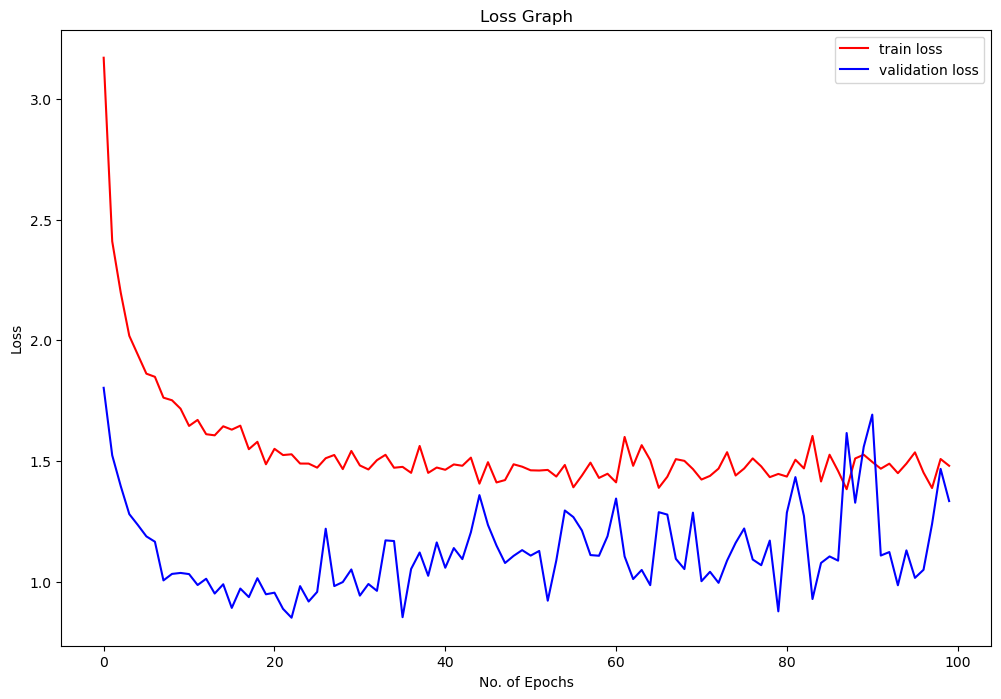

In [44]:
plt.figure(figsize=(12,8))
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='validation loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

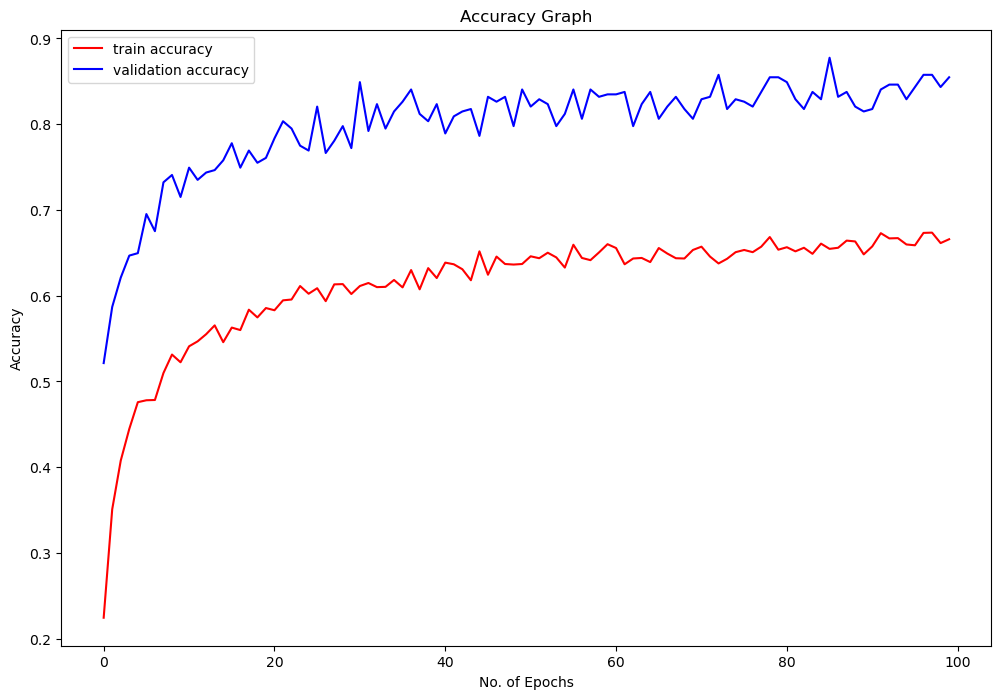

In [45]:
plt.figure(figsize=(12,8))
plt.plot(r.history['accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_accuracy'],'b',label='validation accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [66]:
model.evaluate(test_set)

12/12 [==============================] - 17s 1s/step - loss: 1.0867 - accuracy: 0.8774


[1.0867342948913574, 0.8774373531341553]

In [47]:
model.save('fruits_vegetables_resnet.h5')

## Model accuracy on test data

In [53]:
test_loss, test_accuracy = model.evaluate(test_set)

print('\n\033[1m' + 'The model had an accuracy score of {}%!!'.format(round(100*test_accuracy,1)) + '\033[0m')

12/12 [==============================] - 17s 1s/step - loss: 1.0867 - accuracy: 0.8774

The model had an accuracy score of 87.7%!!


## Xception

In [69]:
import tensorflow.keras.applications.xception as xc
import keras_tuner as kt

In [70]:
train_gen_xc = ImageDataGenerator(
    preprocessing_function=xc.preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_ds_xc = train_gen_xc.flow_from_dataframe(
    dataframe= train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(299, 299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0
)

val_gen_xc = ImageDataGenerator(
    preprocessing_function=xc.preprocess_input
)

val_ds_xc = val_gen_xc.flow_from_dataframe(
    dataframe= val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(299, 299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=0
)

full_train_gen_xc = ImageDataGenerator(
    preprocessing_function=xc.preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

full_train_ds_xc = train_gen_xc.flow_from_dataframe(
        dataframe= train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(299, 299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0
)

test_gen_xc = ImageDataGenerator(
    preprocessing_function=xc.preprocess_input
)

test_ds_xc = test_gen_xc.flow_from_dataframe(
    dataframe= test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(299, 299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=0
)

Found 2780 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.
Found 2780 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.


## Hyperparameter tuning

In [71]:
def model_builder_xc(hp):
    base_model = xc.Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(299, 299, 3)
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(299, 299, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    x = vectors

    for i in range(hp.Int('dense_layers', 1, 4, default=2)):
        hp_units = hp.Int('units_'+str(i), min_value=32, max_value=256, step=32)
        x = keras.layers.Dense(units=hp_units, activation='relu')(x)

    outputs = keras.layers.Dense(36)(x)

    model = keras.Model(inputs, outputs)

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss = keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics = ['accuracy']
    )

    return model

In [72]:
tuner_xc = kt.Hyperband(model_builder_xc,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='xception_models',
                     project_name='xception')

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# Change the TensorBoard folder if needed
tensorboard_logs = keras.callbacks.TensorBoard('/tmp/tb_xc_tuning')

83683744/83683744 [==============================] - 2s 0us/step


In [73]:
tuner_xc.search(
    train_ds_xc,
    validation_data = val_ds_xc,
    epochs = 50,
    callbacks = [stop_early, tensorboard_logs]
)

Trial 30 Complete [00h 26m 45s]
val_accuracy: 0.9281437397003174

Best val_accuracy So Far: 0.955089807510376
Total elapsed time: 05h 23m 35s


In [74]:
model_xc = tuner_xc.get_best_models(1)[0]
model_xc.evaluate(test_ds_xc)

11/11 [==============================] - 18s 2s/step - loss: 0.1901 - accuracy: 0.9551


[0.1901000291109085, 0.955089807510376]

### Final model training based on hyperparmeters on training and validation datasets

In [75]:
def make_xception_model():
    base_model = xc.Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(299, 299, 3)
    )
    base_model.trainable = False

    inputs = keras.Input(shape=(299, 299, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    x = keras.layers.Dense(256, activation='relu')(vectors)
    outputs = keras.layers.Dense(36)(x)

    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate=0.001),
        loss = keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics = ['accuracy']
    )

    return model


In [76]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'model_xc.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

tensorboard_logs = keras.callbacks.TensorBoard('/tmp/tb_xc_final')

In [77]:
final_model_xc = make_xception_model()

history = final_model_xc.fit(
    full_train_ds_xc,
    epochs=10,
    validation_data=val_ds_xc,
    callbacks=[checkpoint, tensorboard_logs]
)

Epoch 1/10
87/87 [==============================] - 163s 2s/step - loss: 1.5584 - accuracy: 0.5924 - val_loss: 0.4901 - val_accuracy: 0.8383
Epoch 2/10
87/87 [==============================] - 161s 2s/step - loss: 0.6688 - accuracy: 0.7788 - val_loss: 0.3522 - val_accuracy: 0.9102
Epoch 3/10
87/87 [==============================] - 159s 2s/step - loss: 0.5045 - accuracy: 0.8299 - val_loss: 0.2897 - val_accuracy: 0.9102
Epoch 4/10
87/87 [==============================] - 159s 2s/step - loss: 0.4171 - accuracy: 0.8633 - val_loss: 0.2689 - val_accuracy: 0.9102
Epoch 5/10
87/87 [==============================] - 159s 2s/step - loss: 0.3525 - accuracy: 0.8741 - val_loss: 0.2713 - val_accuracy: 0.9251
Epoch 6/10
87/87 [==============================] - 160s 2s/step - loss: 0.3278 - accuracy: 0.8881 - val_loss: 0.2115 - val_accuracy: 0.9521
Epoch 7/10
87/87 [==============================] - 158s 2s/step - loss: 0.2786 - accuracy: 0.8932 - val_loss: 0.2113 - val_accuracy: 0.9251
Epoch 8/10
87

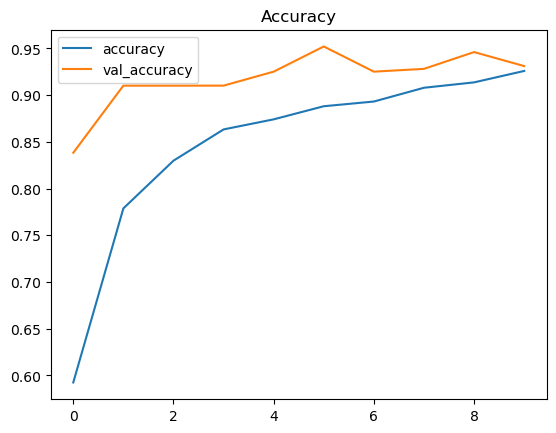

In [78]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

In [79]:
model.save('fruits_vegetables_xception.h5')

# Evaluate perfromance of all three models: 

### MobileNet

In [82]:
final_model_MN = keras.models.load_model("fruits_vegetables_MobileNet.h5")
MN_acuracy = final_model_MN.evaluate(test_images)
MN_acuracy

11/11 [==============================] - 17s 1s/step - loss: 0.1818 - accuracy: 0.9491


[0.1818402260541916, 0.9491018056869507]

### ResNet

In [83]:
final_model_RN = keras.models.load_model("fruits_vegetables_resnet.h5")
RN_acuracy = final_model_RN.evaluate(test_set)
RN_acuracy

12/12 [==============================] - 19s 1s/step - loss: 1.3085 - accuracy: 0.8579


[1.3084778785705566, 0.8579387068748474]

### Xception

In [85]:
final_model_XC = keras.models.load_model("model_xc.h5")
XC_accuracy = final_model_XC.evaluate(test_ds_xc)

11/11 [==============================] - 17s 2s/step - loss: 0.2115 - accuracy: 0.9521


## Mobilenet has the highest accuracy and thus, I will use it for deployment

### Save the final best performed model

In [90]:
import pickle
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False)

#### Checking how our final model perform on image classification

In [ ]:
path1 = './data/eggplant.jpeg'
path2 = './data/beetroot.jpg'
path3 = './data/capsicum.jpg'
img1 = load_img(path1, target_size=(331, 331))
img2 = load_img(path2, target_size=(331, 331))
img3 = load_img(path3, target_size=(331, 331))
x1 = np.array(img1)
x2 = np.array(img2)
x3 = np.array(img3)
X = np.array([x1, x2, x3])
X = nas.preprocess_input(X)
pred = final_model_MN.predict(X)
labels = final_model_MN.class_indices.keys()
res = []
for i in range(len(pred)):
    pred_dict = dict(zip(labels, pred[i]))
    res.append(max(pred_dict, key=pred_dict.get))
res

### Save the model

In [ ]:
model.save('fruits_vegetables_MobileNet.h5')
final_model_MN = keras.models.load_model("fruits_vegetables_MobileNet.h5")